In [1]:
import evaluate.lane 
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import pdb
import glob
import math

# Method 2 (Step by Step)
reference: [Ultimate Guide to Lane Detection ](https://automaticaddison.com/the-ultimate-guide-to-real-time-lane-detection-using-opencv/)

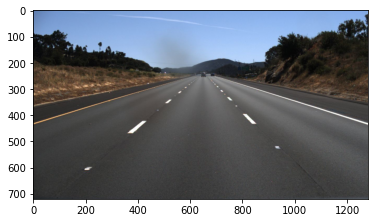

In [2]:

#good example
filename = 'clips/0530/1492626886710588325_0/14.jpg'
# SoSo
#filename = 'clips/0531/1492626718748019090/2.jpg'
# good 
#filename= 'clips/0531/1492626371522989086/4.jpg'
# SoSo
#filename='clips/0531/1492626271917313999/8.jpg'
# good 
#filename = 'clips/0531/1492627478052569489/17.jpg'
#SoSo
#filename = 'clips/0531/1492627837967873644/4.jpg'
# good 
#filename = 'clips/0531/1492628032250037427/2.jpg'
# SoSo
#filename = 'clips/0531/1492627517664589343/10.jpg'
# 
#bad
# filename = 'clips/0531/1492626549851148880/5.jpg'
# good 
#filename = 'clips/0531/1492626292371547028/5.jpg'
# bad
#filename = 'clips/0531/1492626549851148880/19.jpg'

# google map 
#filename = 'googlemap3.jpg'

# medium example
#filename = 'clips/0531/1492626725443010116/2.jpg'

# for cross road example 
#filename = 'clips/0530/1492626127172745520_0/20.jpg'

# car block the sight
#filename = 'clips/0530/1492634972638999132_0/20.jpg'

# turining 
#filename= 'clips/0531/1492721515036902731/20.jpg'

#filename= 'vlcsnap-2021-06-22-15h31m28s205.png'

input_img = mpimg.imread(filename)
height = input_img.shape[0]
width = input_img.shape[1]
if input_img.dtype == np.float32:
    input_img = (input_img*255).astype(np.uint8)
plt.imshow(input_img[:,:,:])


In [3]:
def grayscale(img):
        """
        grayscale, preprocessing for edge detection
        """
        return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
def canny(img,low_threshold=100,high_threshold=300):
        """ Canny edge detection"""
        return cv2.Canny(img,low_threshold,high_threshold,apertureSize = 5,	L2gradient = False)

## perspective_transfrom (轉成鳥瞰) 

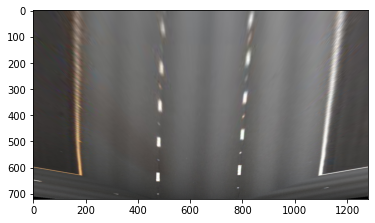

In [4]:
height = input_img.shape[0]
width = input_img.shape[1]
padding = int(0.3 * width)


roi_points = np.float32([
        [width*1/5, height *7/18],
        [-0.2*width, height*8/8],
        [1.2*width, height*8/8],
        [ width*4/5, height *7/18]
        ])
desired_roi_points = np.float32(
    [
      [-2*padding, 0], # Top-left corner
      [padding, height], # Bottom-left corner         
      [width-padding, height], # Bottom-right corner
      [width+2*padding, 0] # Top-right corner
    ])
'''
#這邊需要手動調整
# White Video
roi_points = np.float32([
        [width*7/20, height *11/18],
        [-15/16*width, height],
        [31/16*width, height],
        [width*13/20, height *11/18]
        ])
desired_roi_points = np.float32(
    [
      [0, 0], # Top-left corner
      [0, height], # Bottom-left corner         
      [width, height], # Bottom-right corner
      [width, 0] # Top-right corner
    ])
'''
def perspective_transform(input_img, roi_points, desired_roi_points):
  """
  Perform the perspective transform.
  :param: frame Current frame
  :param: plot Plot the warped image if True
  :return: Bird's eye view of the current lane
  """

  height = input_img.shape[0]
  width = input_img.shape[1]
    
  repeated_img = np.concatenate([input_img[:,width::-1],input_img,input_img[:,-1:-width:-1]],axis=1)
  new_roi_points = np.float32([[x+width,y] for [x,y] in roi_points])
  #這邊需要手動調整

  # Calculate the transformation matrix
  transformation_matrix = cv2.getPerspectiveTransform(
  new_roi_points, desired_roi_points)
  
  # Calculate the inverse transformation matrix           
  inv_transformation_matrix = cv2.getPerspectiveTransform(
    desired_roi_points, roi_points)

  # Perform the transform using the transformation matrix
  #warped_frame = cv2.warpPerspective(lane_line_markings, transformation_matrix, (width, height), flags=(cv2.INTER_LINEAR)) 
  warped_img = cv2.warpPerspective(repeated_img, transformation_matrix, (width, height), flags=(cv2.INTER_LINEAR)) 
  return warped_img , transformation_matrix, inv_transformation_matrix

warped_img , transformation_matrix, inv_transformation_matrix = perspective_transform(input_img,roi_points, desired_roi_points)
plt.imshow(warped_img,cmap='gray')

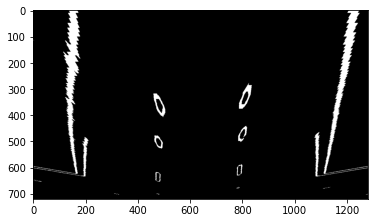

In [5]:
# test wrap after Canny

gray_img=grayscale(input_img)

kernel_size = 35

gray_img = gaussian_blur(gray_img, kernel_size)
canny_img=canny(gray_img)

kernel_size = 5
blur_gray = gaussian_blur(canny_img, kernel_size)
thresh, binary = cv2.threshold(blur_gray,50,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
warped_after_canny, _ , _ = perspective_transform(binary,roi_points, desired_roi_points)

plt.imshow(warped_after_canny,cmap='gray')


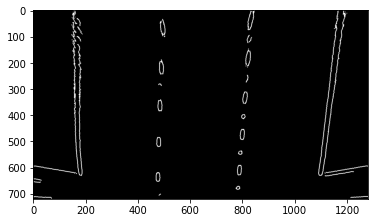

In [6]:

warped_gray_img=grayscale(warped_img)

kernel_size = 35

warped_gray_img = gaussian_blur(warped_gray_img, kernel_size)
warped_canny_img=canny(warped_gray_img)

kernel_size = 5
warped_blur_gray = gaussian_blur(warped_canny_img, kernel_size)
thresh, warped_binary = cv2.threshold(warped_blur_gray,50,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(warped_binary,cmap='gray')

Text(0.5, 1.0, 'Histogram Peaks')

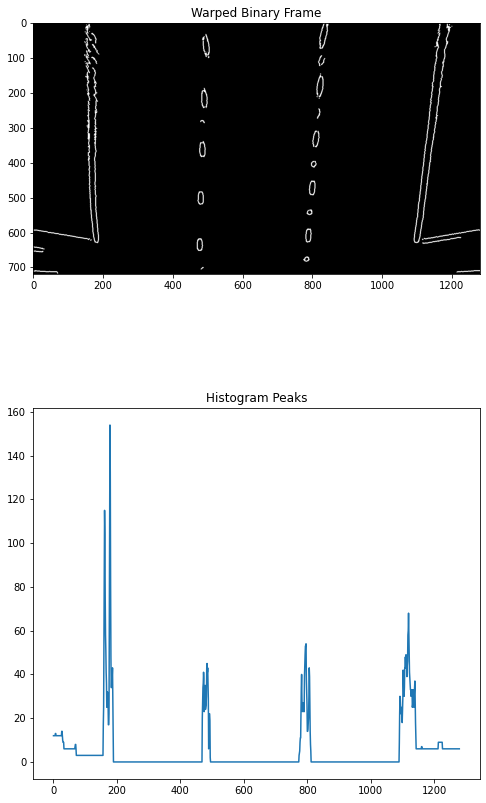

In [7]:

histogram = np.sum(warped_binary[height//2:,:], axis=0)
figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
figure.set_size_inches(8, 15)
ax1.imshow(warped_binary, cmap='gray')
ax1.set_title("Warped Binary Frame")
ax2.plot(histogram)
ax2.set_title("Histogram Peaks")

In [8]:
def find_lane_pixels(binary_warped,k=4):
    height = binary_warped.shape[0]
    width = binary_warped.shape[1]
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    #windows height
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Set the width of the windows +/- margin

    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    histogram = np.sum(binary_warped[height//2:,:], axis=0)
    
    # find the peak of each quaters of the histogram, this will be the starting points of the sliding windows
    x_base = []
    slice_point = np.int(histogram.shape[0]/4)
    for i in range(k):
        x_base.append(np.argmax(histogram[slice_point*i:slice_point*(i+1)])+slice_point*i)
    

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    x_current = []
    # Create empty lists to receive left and right lane pixel indices
    lane_inds = [[] for _ in range(k)]
    for i in x_base:
        x_current.append(i)
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        good_inds = []
        for idx, i in enumerate(x_current):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(i-margin,win_y_low),(i+margin,win_y_high),(0,255,0), 5)
            # Identify the nonzero pixels in x and y within the window
            good_inds =  ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                          (nonzerox >= i-margin) &  (nonzerox < i+margin)).nonzero()[0]
            # Append these indices to the lists
            lane_inds[idx].append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current[idx] = np.int(np.mean(nonzerox[good_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        for idx, i in enumerate(lane_inds):
            lane_inds[idx]=np.concatenate(lane_inds[idx])
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions
    pos_x,pos_y = [],[]
    for i in lane_inds:
        pos_x.append(nonzerox[i])
        pos_y.append(nonzeroy[i])

    return pos_x, pos_y, out_img, lane_inds

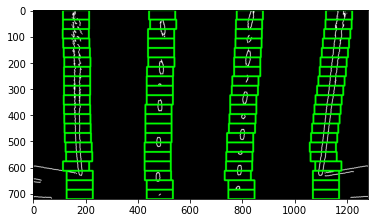

In [9]:

pos_x, pos_y, out_img, lane_inds = find_lane_pixels(warped_binary)
plt.imshow(out_img)


In [10]:
def fit_poly(x,y,degree=2):
    "fit several poly lines based on "
    k = len(x)
    # Find our lane pixels first
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    fits = []
    for i in range(k):
        fits.append(np.polyfit(y[i], x[i], degree))

    return  fits

def sample_fit(fits, y_samples):
    "sample the fitting polynomials on a sequence of y values"
    fitx = []
   
    for fit in fits:
            Degree = len(fit) - 1
            fitx.append(np.sum(np.stack([f* y_samples**(Degree-i) for i, f in enumerate(fit)],axis=1),axis=1))
            #fitx.append(fit[0]*ploty**2 + fit[1]*ploty + fit[2])
   
    return fitx

## Fit After unwarped 

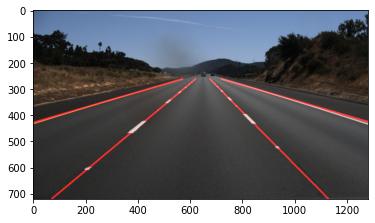

In [11]:


# transform edge points from sliding window back to original coordinate
pts_unwarped = []
for xs, ys in zip(pos_x, pos_y):
    pts_homo = np.stack([xs,ys,np.ones(shape=(len(xs),))],axis=1)
    pts_unwarped_homo = (inv_transformation_matrix @ pts_homo.T ).T
    unwarped = pts_unwarped_homo[:,:-1] / pts_unwarped_homo[:,[-1]]
    pts_unwarped.append(unwarped)


fits = fit_poly([p[:,0] for p in pts_unwarped],[p[:,1] for p in pts_unwarped],degree=1)

# Generate x and y values for plotting
# This is for  fitting on warped coordinate
#sample_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

# This is for fitting on original coordinate
roi_min_y = roi_points[0][1]-height//40
roi_max_y = roi_points[1][1]
sample_y  = np.linspace(roi_min_y,roi_max_y,int(roi_max_y - roi_min_y))

sample_xs = sample_fit(fits, sample_y)

fit_pts = [[[x,y] for x,y in zip(xs,sample_y)] for xs in sample_xs]

line_img=np.zeros((input_img.shape[0],input_img.shape[1],input_img.shape[2]),dtype=np.uint8)
cv2.polylines(line_img,np.int32(fit_pts),isClosed=False,color=[255,0,0],thickness=5)

img=cv2.addWeighted(input_img, 0.8, line_img, 1.0, 0.0)
plt.imshow(img)


# Method 2 (Pipeline)

In [12]:
def pipeline(input_img,return_x_samples=False,h_vals = None):
    height = input_img.shape[0]
    width = input_img.shape[1]
    padding = int(0.3 * width)
    
    # Warp -> Canny

    warped_img , transformation_matrix, inv_transformation_matrix = perspective_transform(input_img, roi_points, desired_roi_points)

    warped_gray_img=grayscale(warped_img)

    kernel_size = 31

    warped_gray_img = gaussian_blur(warped_gray_img, kernel_size)
    warped_canny_img=canny(warped_gray_img)

    kernel_size = 5
    warped_blur_gray = gaussian_blur(warped_canny_img, kernel_size)
    
    thresh, warped_binary = cv2.threshold(warped_blur_gray,50,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)  
    '''

    # Canny -> Warp
    gray_img=grayscale(input_img)

    kernel_size = 31

    gray_img = gaussian_blur(gray_img, kernel_size)
    canny_img=canny(gray_img)

    kernel_size = 5
    blur_gray = gaussian_blur(canny_img, kernel_size)
    thresh, binary = cv2.threshold(blur_gray,50,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    warped_bianry, transformation_matrix , inv_transformation_matrix = perspective_transform(binary,roi_points,  desired_roi_points)
    
    '''
    
    pos_x, pos_y, out_img, lane_inds = find_lane_pixels(warped_binary,k=4)

    

    # transform edge points from sliding window back to original coordinate
    pts_unwarped = []
    for xs, ys in zip(pos_x, pos_y):
       pts_homo = np.stack([xs,ys,np.ones(shape=(len(xs),))],axis=1)
       pts_unwarped_homo = (inv_transformation_matrix @ pts_homo.T ).T
       unwarped = pts_unwarped_homo[:,:-1] / pts_unwarped_homo[:,[-1]]
       pts_unwarped.append(unwarped)



    fits = fit_poly([p[:,0] for p in pts_unwarped],[p[:,1] for p in pts_unwarped],degree=1)

    # This is for fitting on original coordinate
    roi_min_y = roi_points[0][1]-height/40
    roi_max_y = roi_points[1][1]
    sample_y  = np.linspace(roi_min_y,roi_max_y,int(roi_max_y - roi_min_y))

    sample_xs = sample_fit(fits, sample_y)

    fit_pts = [[[x,y] for x,y in zip(xs,sample_y)] for xs in sample_xs]

    line_img=np.zeros((input_img.shape[0],input_img.shape[1],input_img.shape[2]),dtype=np.uint8)
    cv2.polylines(line_img,np.int32(fit_pts),isClosed=False,color=[255,0,0],thickness=5)

    result_img=cv2.addWeighted(input_img, 0.8, line_img, 1.0, 0.0)

    if return_x_samples: 
        sample_xs = sample_fit(fits, h_vals)
        for i, xs in enumerate(sample_xs):
            for j, (x, y) in enumerate(zip(xs, h_vals)):
                if y < roi_min_y or y > roi_max_y:
                    sample_xs[i][j] = -2
                if x > width or x < 0:
                    sample_xs[i][j] = -2
        return result_img, sample_xs

    return result_img


# Save processed clips as video

In [370]:
def process_image(get_frame,time,add_file_name = False):
    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image = get_frame(time)
    result= pipeline(image)
    #result = np.concatenate([line_sort,final],axis=1)

    if add_file_name:
        
        frame_number = math.floor(time * 15)
        file_name = file[frame_number//20]
        image_name = str(frame_number%20)
        text = 'clips/0530/'+file_name+'/'+image_name+'.jpg'
        cv2.putText(result, text,[100,100],fontFace = cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=[255,0,0],thickness = 2,lineType=cv2.LINE_AA)

    
    return result

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip, concatenate_videoclips
from IPython.display import HTML
import glob

### save tusiple frames as video

In [372]:
path_head = 'clips/0530/'
file = ['1492626886710588325_0','1492626888709649298_0','1492626893706409672_0','1492626894705755667_0','1492626896704559322_0']
# turning #
path_head = 'clips/0531/'
file = ['1492721515036902731','1492721518501554866','1492721519534188341','1492721523667719442','1492721524664443125']
#file = ['1492627031625585314_0','1492627032622200926_0','1492627045614528253_0','1492627051610632948_0','1492627054611277310_0']
clips = []
for i in file:
    images_list = (glob.glob(path_head+i+'/*.jpg'))
    images_list = sorted(images_list, key=lambda str: int(str.split('/')[-1].split('.')[0]))
    #print(images_list)
    clip = ImageSequenceClip(images_list, fps=15)
    clips.append(clip.fl(lambda a ,b : process_image(a,b,add_file_name= False)))
video = concatenate_videoclips(clips,method='compose')
video.write_videofile(f'Results/Tusimple_M2_{file[0]}_degree2.mp4',audio=False)

KeyboardInterrupt: 

### Process input video and save output video 

In [537]:
white_output = 'test_videos_output/solidWhiteRight_M2.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]Moviepy - Building video test_videos_output/solidWhiteRight_M2.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight_M2.mp4

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight_M2.mp4
CPU times: user 11.5 s, sys: 1.48 s, total: 13 s
Wall time: 13.4 s


# Method 2 (Test Accuracy)
## for single image

In [14]:
import json
import time 
from evaluate.lane import LaneEval
ground_truth = [json.loads(line) for  line in open('jsons/test_label.json').readlines()]

In [15]:
### find test_image by index
gt_index = 100
gt = ground_truth[gt_index]
image_file_path = gt['raw_file']
gt_lanes = gt['lanes']
gt_hs = gt['h_samples']
test_img = mpimg.imread(image_file_path)
print(image_file_path)

clips/0530/1492626507943650406_0/20.jpg


duration=0.13539814949035645


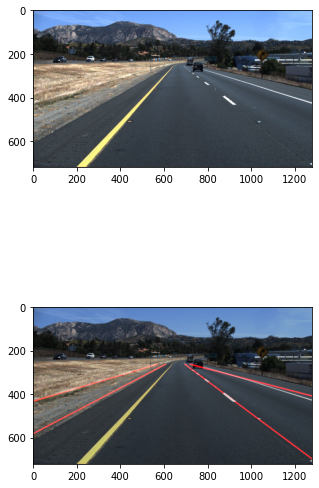

In [16]:
start_t = time.time()
result, lane_pred = pipeline(test_img, return_x_samples=True,h_vals=np.array(gt_hs))
end_t = time.time()

print(f'duration={end_t - start_t}')
f,ax = plt.subplots(2,1)
f.set_figheight(10)
f.set_figwidth(5)
ax[0].imshow(test_img)
ax[1].imshow(result)

In [17]:
acc, fp, fn = LaneEval.bench(lane_pred, gt_lanes, gt_hs,200)
print(f'acc={acc:.4}, fp={fp}, fn={fn}')

acc=0.6964, fp=0.5, fn=0.3333333333333333


## Accuracy for first 500 images

In [374]:
test_start_index = 0
test_end_index = 500
acc = []
fp = []
fn = []
for i in range(test_start_index,test_end_index):
    print(f'{i}-',end='')
    gt = ground_truth[i]
    image_file_path = gt['raw_file']
    gt_lanes = gt['lanes']
    gt_hs = gt['h_samples']
    test_img = mpimg.imread(image_file_path)
    result, lane_pred = pipeline(test_img, return_x_samples=True,h_vals=np.array(gt_hs))
    acc_i, fp_i, fn_i = LaneEval.bench(lane_pred, gt_lanes, gt_hs,200)
    acc.append(acc_i)
    print(acc_i, image_file_path)
    fp.append(fp_i)
    fn.append(fn_i)

print('')
print(f'Acc mean = {np.mean(np.array(acc))}')
print(f'FP mean = {np.mean(np.array(fp))}')
print(f'FN mean = {np.mean(np.array(fn))}')


8572 clips/0530/1492637972300034228_0/20.jpg
1080-0.8883928571428573 clips/0530/1492638450011631841_0/20.jpg
1081-0.9776785714285716 clips/0530/1492638788810084635_0/20.jpg
1082-0.9345238095238094 clips/0530/1492637956309692731_0/20.jpg
1083-0.7440476190476191 clips/0530/1492638001282511188_0/20.jpg
1084-0.9910714285714286 clips/0530/1492638536959201655_0/20.jpg
1085-0.8452380952380952 clips/0530/1492638101224747404_0/20.jpg
1086-0.9107142857142856 clips/0530/1492638597922435915_0/20.jpg
1087-0.84375 clips/0530/1492638676874777066_0/20.jpg
1088-0.8660714285714284 clips/0530/1492638922734277126_0/20.jpg
1089-0.7559523809523809 clips/0530/1492637877357310518_0/20.jpg
1090-0.8571428571428572 clips/0530/1492638740836086364_0/20.jpg
1091-0.9196428571428573 clips/0530/1492638948710552190_0/20.jpg
1092-0.9687500000000001 clips/0530/1492638771817779899_0/20.jpg
1093-0.8214285714285715 clips/0530/1492637981294736087_0/20.jpg
1094-0.9583333333333334 clips/0530/1492637871360889605_0/20.jpg
1095-0